Newton  0: |A+|=    0, |A-|=    0, |A|=    0
         CG iters=4000, relres=1.07e-01, step=4.92s
Newton  1: |A+|=43540, |A-|=16948, |A|=60488
         CG iters=430, relres=9.94e-07, step=1.40s
Newton  2: |A+|=22892, |A-|= 9164, |A|=32056
         CG iters=663, relres=9.65e-07, step=0.78s
Newton  3: |A+|=18792, |A-|= 8340, |A|=27132
         CG iters=1190, relres=9.93e-07, step=1.77s
Newton  4: |A+|=13300, |A-|= 6916, |A|=20216
         CG iters=1463, relres=9.97e-07, step=1.59s
Newton  5: |A+|=16536, |A-|= 6040, |A|=22576
         CG iters=1497, relres=9.91e-07, step=2.97s
Newton  6: |A+|=12436, |A-|= 5148, |A|=17584
         CG iters=1421, relres=9.95e-07, step=1.76s
Newton  7: |A+|=14104, |A-|= 5164, |A|=19268
         CG iters=1696, relres=9.86e-07, step=1.79s
Newton  8: |A+|=12300, |A-|= 4408, |A|=16708
         CG iters=1918, relres=9.83e-07, step=2.11s
Newton  9: |A+|=13868, |A-|= 4088, |A|=17956
         CG iters=2093, relres=9.99e-07, step=2.20s
Newton 10: |A+|=12028, |A-|= 393

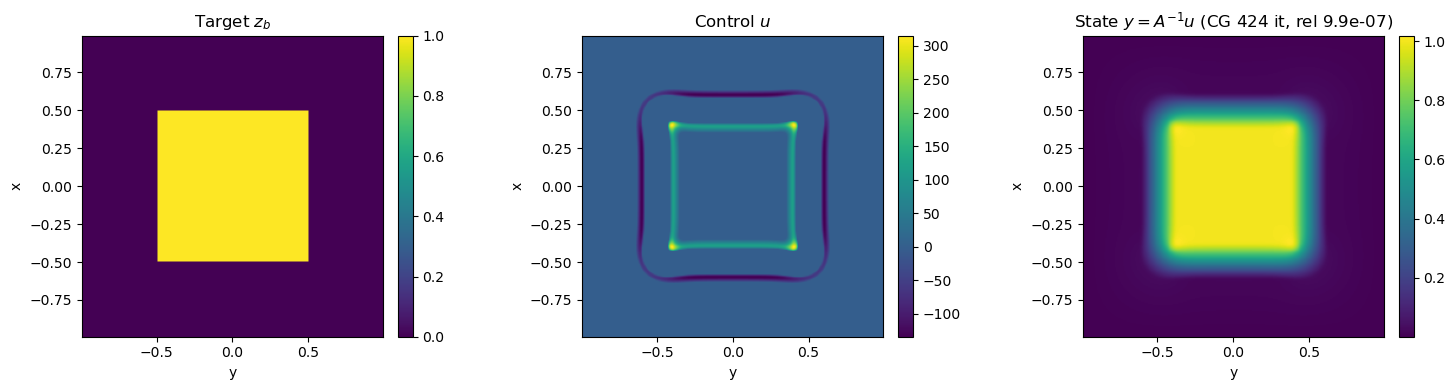

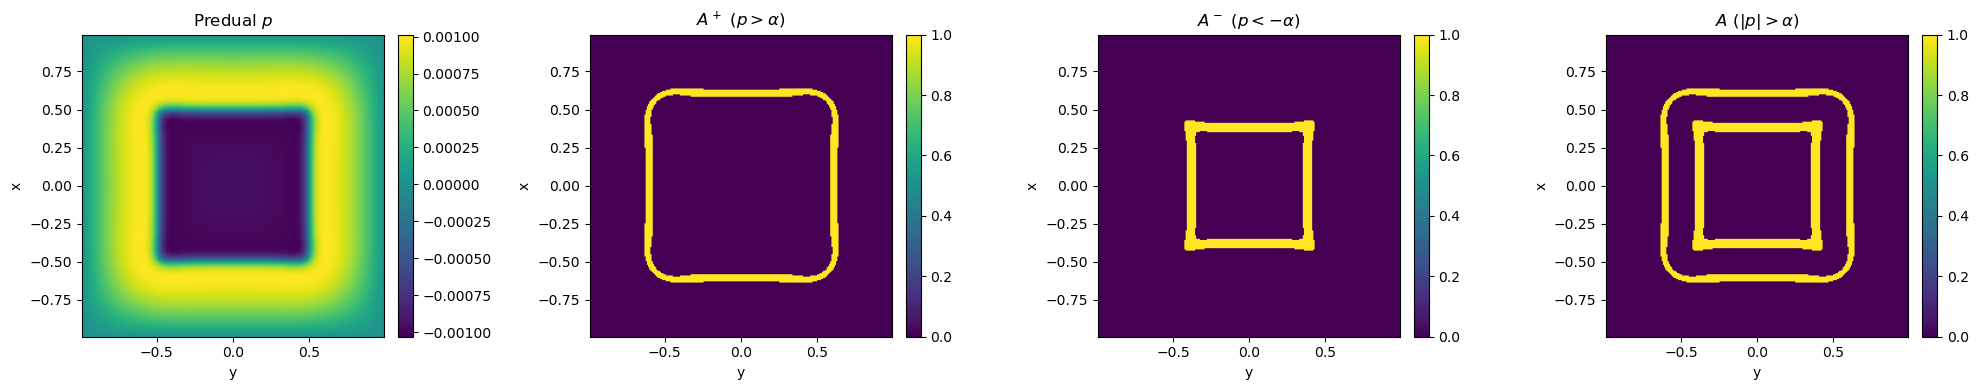

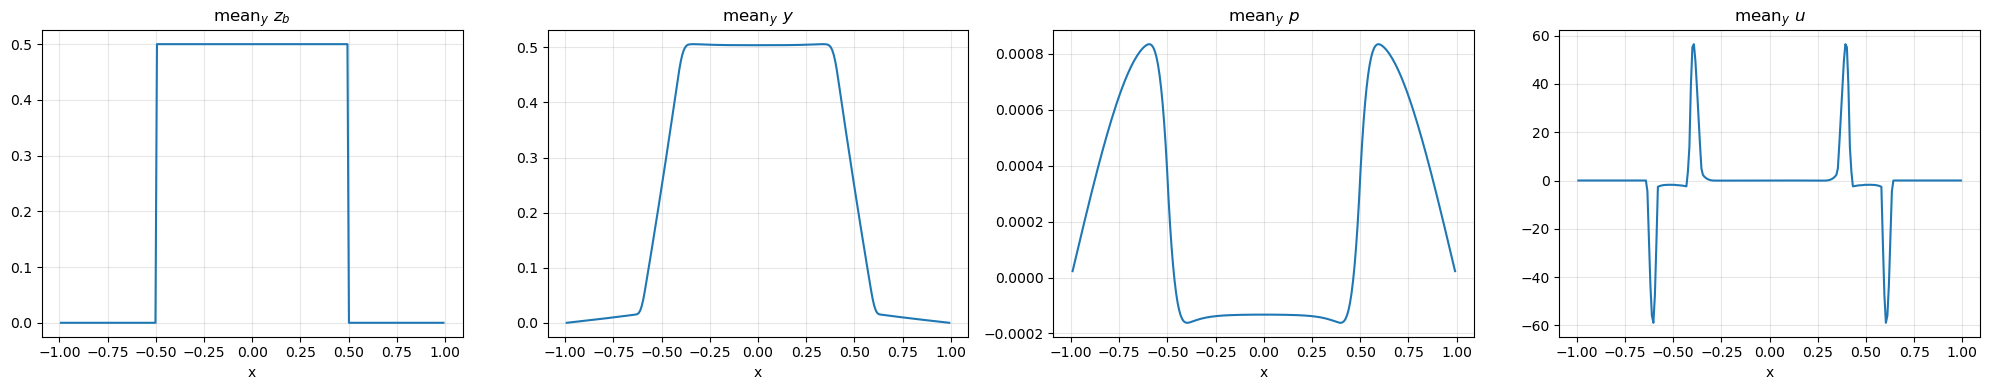

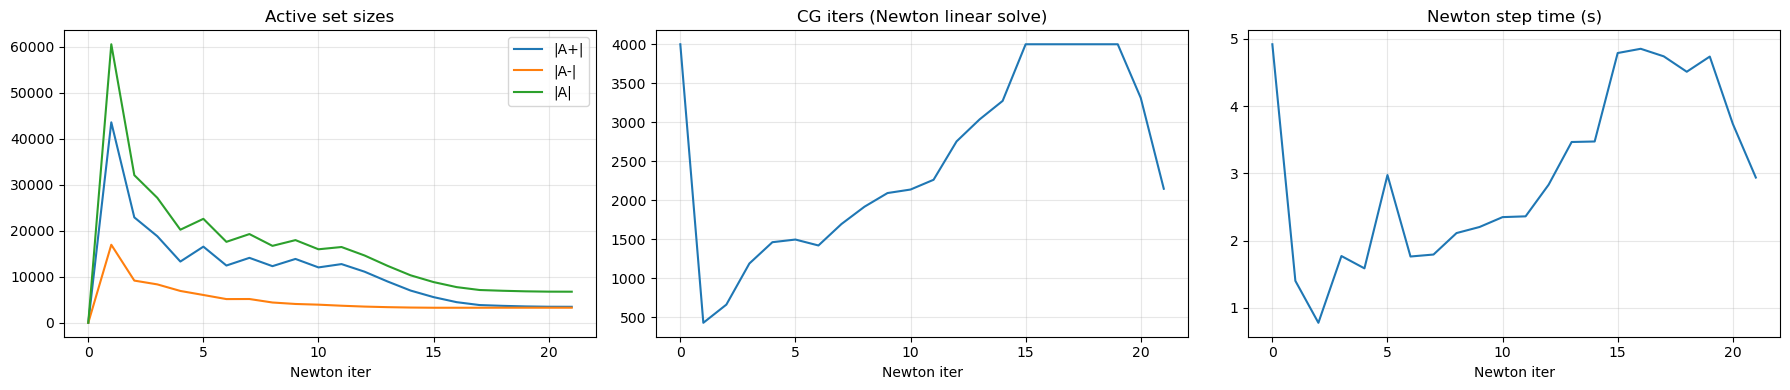

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ============================================================
# Example problem Clason-Kunisch
# ============================================================
# PDE:         A_D y = u        in Ω,  y=0 on ∂Ω
# Tracking:    z ≡ 1_{|x|<1/2, |y|<1/2}, minimize 1/2||y - z||^2 + α||u||_M
#
# Predual MY semismooth Newton:
#   Solve:  A_D^2 p + λ(p) = g
#   where:  λ(p) = max(0, c(p-α)) + min(0, c(p+α))
#   then:   u = λ(p)
#           y solves A_D y = u
#
# Domain: Ω = [-1,1]^2, Dirichlet boundary, N×N interior grid
# A_D = -DΔ (constant D>0), discretized by 5-point stencil for -Δ.
# ============================================================

# -----------------------------
# Grid + target z_b
# -----------------------------
def make_grid(N, a=-1.0, b=1.0):
    h = (b - a) / (N + 1)
    x = a + h * np.arange(1, N + 1)
    y = a + h * np.arange(1, N + 1)
    X, Y = np.meshgrid(x, y, indexing="ij")
    return X, Y, h

def target_zb(X, Y):
    return ((np.abs(X) < 0.5) & (np.abs(Y) < 0.5)).astype(float)

# -----------------------------
# Discrete A = -Δ (Dirichlet)
# -----------------------------
def apply_A(u, h):
    N = u.shape[0]
    up = np.zeros((N + 2, N + 2), dtype=u.dtype)
    up[1:-1, 1:-1] = u
    return (
        4.0 * up[1:-1, 1:-1]
        - up[2:, 1:-1]
        - up[:-2, 1:-1]
        - up[1:-1, 2:]
        - up[1:-1, :-2]
    ) / (h * h)

def apply_A2(u, h):
    return apply_A(apply_A(u, h), h)

# -----------------------------
# Matrix-free CG
# -----------------------------
def cg(apply_op, b, x0=None, tol=1e-6, maxiter=200):
    x = np.zeros_like(b) if x0 is None else x0.copy()
    r = b - apply_op(x)
    p = r.copy()
    rr_old = float(np.vdot(r, r))
    b_norm = np.sqrt(float(np.vdot(b, b))) + 1e-30

    for k in range(maxiter):
        Ap = apply_op(p)
        pAp = float(np.vdot(p, Ap))
        if pAp <= 0:
            break
        alpha = rr_old / pAp
        x += alpha * p
        r -= alpha * Ap
        rr_new = float(np.vdot(r, r))
        if np.sqrt(rr_new) / b_norm < tol:
            return x, k + 1, np.sqrt(rr_new) / b_norm
        beta = rr_new / rr_old
        p = r + beta * p
        rr_old = rr_new

    return x, maxiter, np.sqrt(rr_old) / b_norm

# -----------------------------
# Semismooth Newton (Alg 1)
# -----------------------------
def solve_measure_control_zb(
    N=48,
    alpha=1e-3,
    c=1e7,
    newton_maxiter=15,
    cg_tol=1e-6,
    cg_maxiter=200,
    verbose=True,
):
    X, Y, h = make_grid(N)
    z = target_zb(X, Y)
    Az = apply_A(z, h)

    p = np.zeros_like(z)
    Aplus_prev = None
    Aminus_prev = None

    hist = {"k": [], "Aplus": [], "Aminus": [], "cg_iters": [], "cg_relres": [], "sec": []}

    for k in range(newton_maxiter):
        t0 = time.time()

        Aplus = (p > alpha)
        Aminus = (p < -alpha)
        A = Aplus | Aminus

        if verbose:
            print(f"Newton {k:2d}: |A+|={Aplus.sum():5d}, |A-|={Aminus.sum():5d}, |A|={A.sum():5d}")

        if (Aplus_prev is not None
            and np.array_equal(Aplus, Aplus_prev)
            and np.array_equal(Aminus, Aminus_prev)):
            if verbose:
                print("Active sets unchanged -> terminate.")
            break

        Aplus_prev = Aplus.copy()
        Aminus_prev = Aminus.copy()

        rhs = -Az + c * alpha * (Aplus.astype(float) - Aminus.astype(float))

        def apply_lin(x):
            return apply_A2(x, h) + c * (A.astype(float) * x)

        p, iters, relres = cg(apply_lin, rhs, x0=p, tol=cg_tol, maxiter=cg_maxiter)

        t1 = time.time()
        hist["k"].append(k)
        hist["Aplus"].append(int(Aplus.sum()))
        hist["Aminus"].append(int(Aminus.sum()))
        hist["cg_iters"].append(int(iters))
        hist["cg_relres"].append(float(relres))
        hist["sec"].append(float(t1 - t0))

        if verbose:
            print(f"         CG iters={iters:3d}, relres={relres:.2e}, step={t1-t0:.2f}s")

    u = apply_A2(p, h) + Az
    return X, Y, h, z, p, u, hist

# -----------------------------
# Solve state y = A^{-1} u
# -----------------------------
def solve_state(u, h, tol=1e-6, maxiter=500, x0=None):
    def apply_lin(y):
        return apply_A(y, h)
    return cg(apply_lin, u, x0=x0, tol=tol, maxiter=maxiter)

# -----------------------------
# Plotting
# -----------------------------
def imshow_field(ax, X, Y, F, title):
    extent = [Y.min(), Y.max(), X.min(), X.max()]
    im = ax.imshow(F, origin="lower", extent=extent, aspect="equal")
    ax.set_title(title)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    return im

def visualize_all(X, Y, z, p, u, y, alpha, hist, y_info):
    # 1) z, u, y
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    im = imshow_field(axes[0], X, Y, z, r"Target $z_b$")
    plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
    im = imshow_field(axes[1], X, Y, u, r"Control $u$")
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    im = imshow_field(axes[2], X, Y, y, rf"State $y=A^{{-1}}u$ (CG {y_info[0]} it, rel {y_info[1]:.1e})")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    plt.tight_layout()

    # 2) p and active sets
    Aplus = (p > alpha).astype(float)
    Aminus = (p < -alpha).astype(float)
    A = (np.abs(p) > alpha).astype(float)

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    im = imshow_field(axes[0], X, Y, p, r"Predual $p$")
    plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
    im = imshow_field(axes[1], X, Y, Aplus, r"$A^+$ ($p>\alpha$)")
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    im = imshow_field(axes[2], X, Y, Aminus, r"$A^-$ ($p<-\alpha$)")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    im = imshow_field(axes[3], X, Y, A, r"$A$ ($|p|>\alpha$)")
    plt.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)
    plt.tight_layout()

    # 3) Projections (mean over y)
    xcoord = X[:, 0]
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    axes[0].plot(xcoord, z.mean(axis=1)); axes[0].grid(True, alpha=0.3); axes[0].set_title(r"mean$_y$ $z_b$")
    axes[1].plot(xcoord, y.mean(axis=1)); axes[1].grid(True, alpha=0.3); axes[1].set_title(r"mean$_y$ $y$")
    axes[2].plot(xcoord, p.mean(axis=1)); axes[2].grid(True, alpha=0.3); axes[2].set_title(r"mean$_y$ $p$")
    axes[3].plot(xcoord, u.mean(axis=1)); axes[3].grid(True, alpha=0.3); axes[3].set_title(r"mean$_y$ $u$")
    for ax in axes: ax.set_xlabel("x")
    plt.tight_layout()

    # 4) Convergence diagnostics
    if len(hist["k"]) > 0:
        k = np.array(hist["k"])
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        axes[0].plot(k, hist["Aplus"], label="|A+|")
        axes[0].plot(k, hist["Aminus"], label="|A-|")
        axes[0].plot(k, np.array(hist["Aplus"]) + np.array(hist["Aminus"]), label="|A|")
        axes[0].grid(True, alpha=0.3); axes[0].set_title("Active set sizes"); axes[0].set_xlabel("Newton iter"); axes[0].legend()

        axes[1].plot(k, hist["cg_iters"])
        axes[1].grid(True, alpha=0.3); axes[1].set_title("CG iters (Newton linear solve)"); axes[1].set_xlabel("Newton iter")

        axes[2].plot(k, hist["sec"])
        axes[2].grid(True, alpha=0.3); axes[2].set_title("Newton step time (s)"); axes[2].set_xlabel("Newton iter")
        plt.tight_layout()

    plt.show()

# -----------------------------
# Run (fast, then scale up)
# -----------------------------
N = 256          # try 48 first; then 64; then 96; then 128
alpha = 1e-3
c = 1e7

X, Y, h, z, p, u, hist = solve_measure_control_zb(
    N=N, alpha=alpha, c=c,
    newton_maxiter=50, cg_tol=1e-6, cg_maxiter=4000,
    verbose=True
)

# final state y = A^{-1} u
y, y_iters, y_rel = solve_state(u, h, tol=1e-6, maxiter=800, x0=None)

visualize_all(X, Y, z, p, u, y, alpha=alpha, hist=hist, y_info=(y_iters, y_rel))
